# Credit Score Classification


In the taken dataset of the Global finance company, we are tasked with developing an automated system to categorize individuals based on their creditworthiness. Over the years, the company has collected a wealth of credit-related information, and now the management wants to build an intelligent system to segregate people into credit score brackets, reducing manual efforts.

Our task involves leveraging the available credit-related data to train a predictive model that can effectively categorize individuals based on their credit scores. This model will play a crucial role in automating the assessment of creditworthiness, enabling us to make informed decisions efficiently.

To accomplish this, we'll need to preprocess the data, engineer relevant features, and select appropriate algorithms for training the model. Once trained, our model will be capable of classifying new individuals into predefined credit score categories, contributing to our company's goal of enhancing efficiency and accuracy in credit assessment processes.

# Load The Data and requisite libraries

In [ ]:
# run  this cell only if you have errors related to libraries.
!pip uninstall scikit-learn imbalanced-learn
!pip install scikit-learn imbalanced-learn
!pip install category_encoders
!pip install xgboost
!pip install catboost
!pip uninstall scikit-learn
!pip install scikit-learn

In [1]:
# Packages for EDA 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np 

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import category_encoders as ce
import re 

# Modeling and evaluation 
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
import joblib

# Packages options 
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all 
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

import warnings 
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df = pd.read_csv("../input/credit-score-classification/train.csv",low_memory=False)
df.head(5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


# Prelimininary Data Univariate Inspection

In [3]:
df.shape

(100000, 28)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Understood that there are a lot of missing values and wrong data types (object) assigned to obviously numerical features like Age, Annual Income

In [5]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


Understood many data anomalies in the Numerical features like  Num_Bank_Accounts has values like -1 Delay_from_due_date has  -5. There are also extreme outliers Interest_Rate of 5797%. I have chosen to retain the outliers as in most cases the outlier information is very important in classifying their credit score. 

In [6]:
df.duplicated().sum()

0

There are no duplicates in the data

Analysing Categorical Data

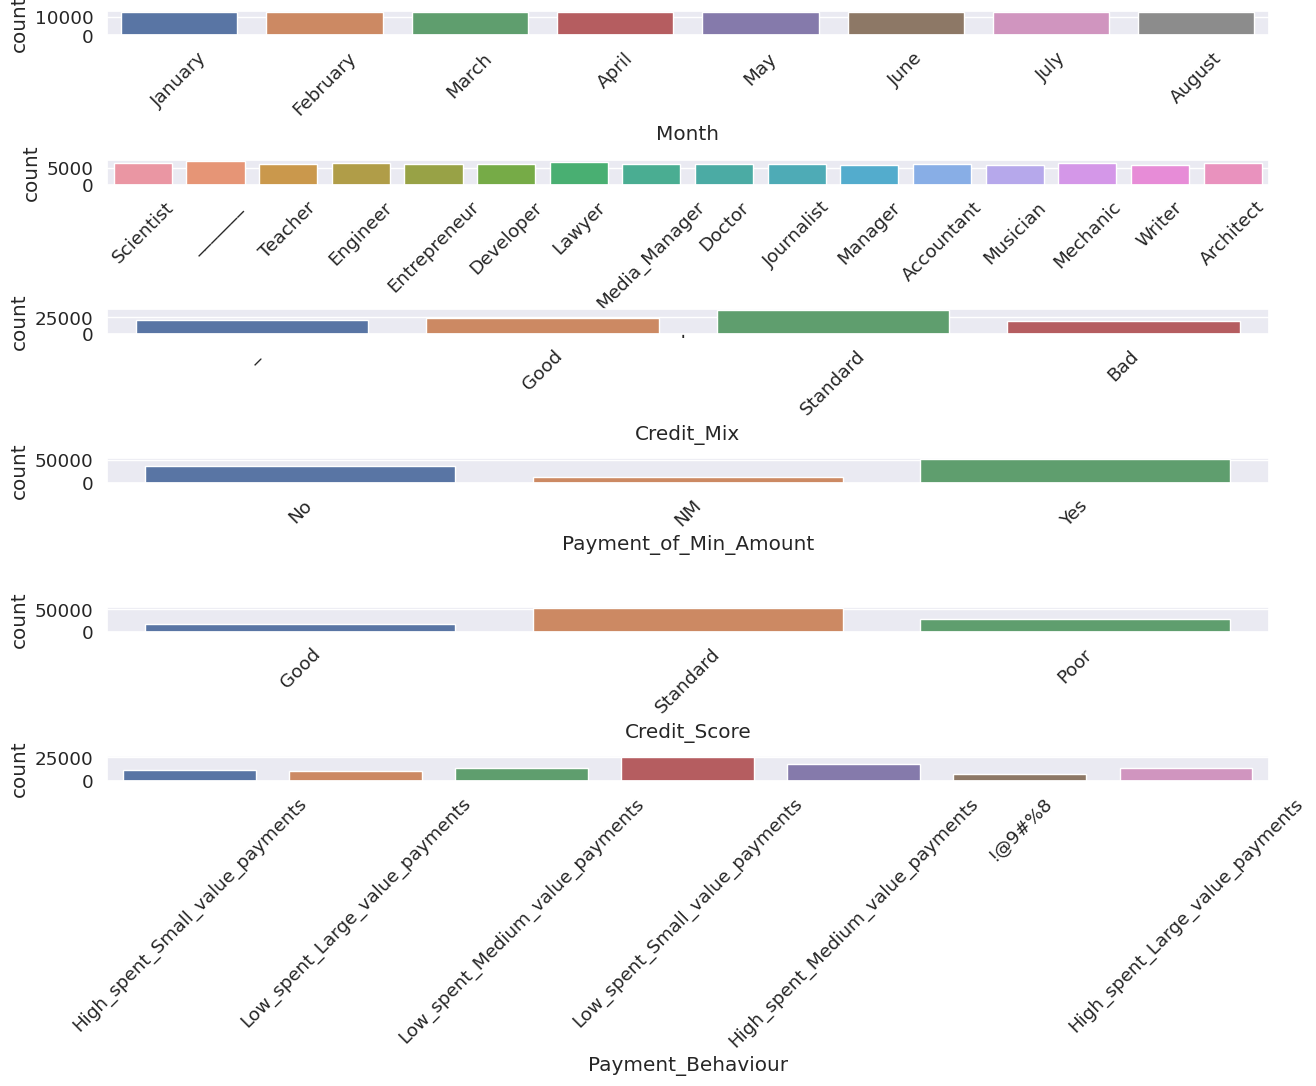

In [7]:
fig, axis = plt.subplots(nrows=6, ncols=1, figsize=(15,10))
fig.subplots_adjust(hspace=5)

sns.countplot(x=df["Month"], ax=axis[0])
axis[0].tick_params(axis='x', rotation=45)

sns.countplot(x=df["Occupation"], ax=axis[1])
axis[1].tick_params(axis='x', rotation=45)

sns.countplot(x=df["Credit_Mix"], ax=axis[2])
axis[2].tick_params(axis='x', rotation=45)

sns.countplot(x=df["Payment_of_Min_Amount"], ax=axis[3])
axis[3].tick_params(axis='x', rotation=45)

sns.countplot(x=df["Credit_Score"], ax=axis[4])
axis[4].tick_params(axis='x', rotation=45)

sns.countplot(x=df["Payment_Behaviour"], ax=axis[5])
axis[5].tick_params(axis='x', rotation=45)

plt.show()


In [ ]:
We can see that there are a few wrong entries like "_" and "!@9#%8" that should be converted into Null 

# Data Preprocessing

We will have do data preprocessing for the following issues in the dataset

1. The columns ID, Cust_ID, SSN, Name are not useful are the categorization

2. Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Amount_invested_monthly, Outstanding_Debt,

    Credit_Mix, Monthly_Balance Numerical but show as catogery (need to be fixed)

3.Missing entries:
   
      A lot of missing data
   
      Occupation, CreditMix has value "__" 

4. Wrong entries:
   
    Num_Bank_Accounts contains negative values
    
5. Feature Engineering 

    Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Credit_Mix, 
    
    Type_of_Loan,Num_Bank_Accounts

    

In [8]:
## The columns ID, SSN, Name are not useful are the categorization

df.drop(["ID","Name","SSN"],axis=1, inplace=True)

In [9]:
df.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,CUS_0xd40,February,23,Scientist,19114.12,NaN,3,4,3,4,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,CUS_0xd40,March,-500,Scientist,19114.12,NaN,3,4,3,4,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,CUS_0xd40,April,23,Scientist,19114.12,NaN,3,4,3,4,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


# Handling Numerical variables

Handling wrong typecasting

In [10]:
N_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 
            'Changed_Credit_Limit','Amount_invested_monthly', 'Outstanding_Debt' , 'Monthly_Balance']

In [11]:
for i in N_to_fix:
    df[i] = pd.to_numeric(df[i], errors='coerce').fillna(0).astype(float)


This step does the following
1. Conert "object" data types into Numerical 
2. The values that are numerical will be converted to numerical and the values that cannot be converted into numerical will be coerced to become Null, on which we will do imputation

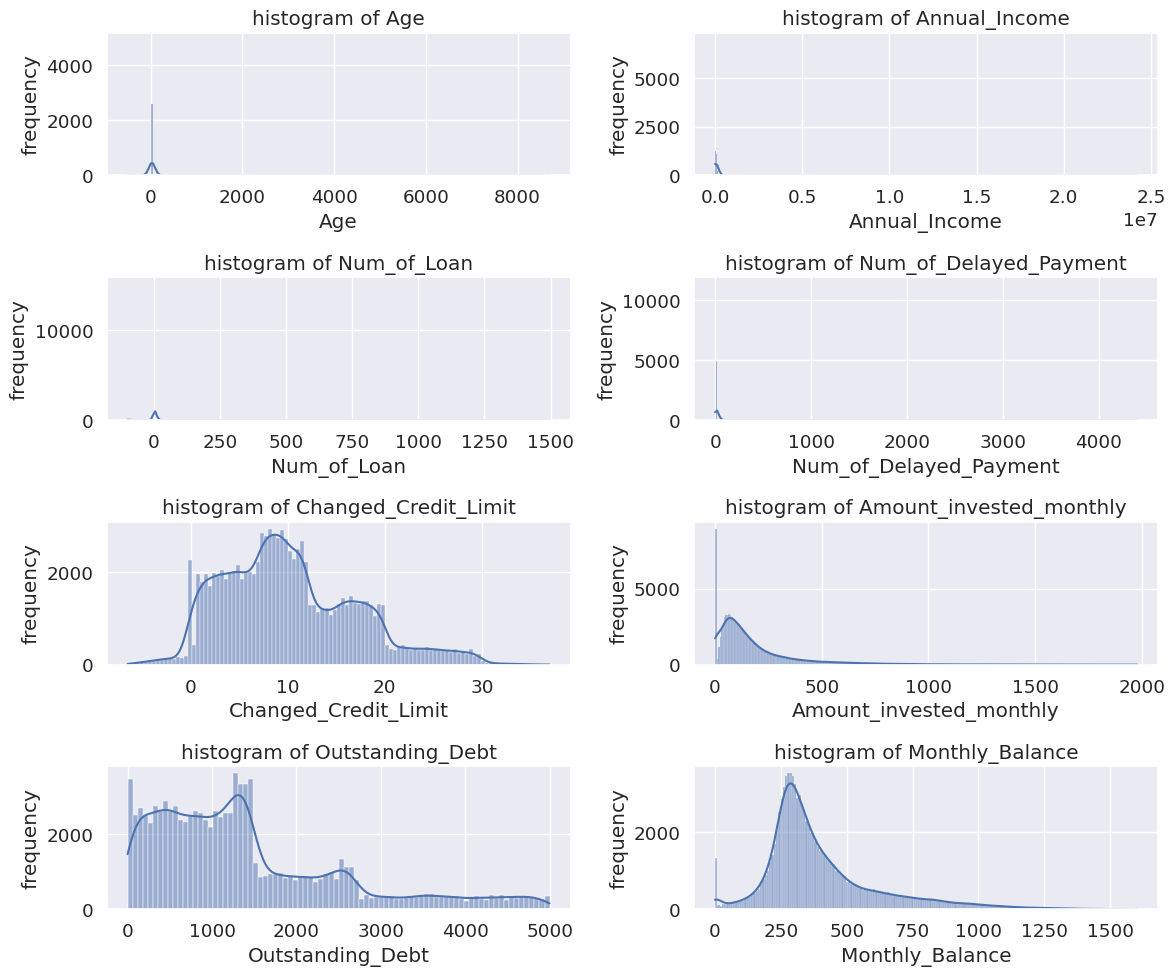

In [16]:
fig,axis=plt.subplots(nrows=4,ncols=2,figsize=(12,10))
k=axis.flatten()
for i,p in zip(N_to_fix,k):
    sns.histplot(x=df[i],ax=p,kde=True)
    p.set_title(f"histogram of {i}")
    p.set_xlabel(i)
    p.set_ylabel("frequency")
plt.tight_layout()
plt.show()

Type_of_loan

It has multiple types of loans and not all are important so create dummy column for 9 most frequent types of loan

In [17]:
for i in df["Type_of_Loan"].value_counts().head(9).index[1:]:
    df[i] = df["Type_of_Loan"].fillna('').str.contains(i).astype(int)
del df["Type_of_Loan"]


In [18]:
## We can see the 9 additional columns having the type of loans
df.head(5)

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,CUS_0xd40,January,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,...,312.494089,Good,1,1,0,0,0,0,1,1
1,CUS_0xd40,February,23.0,Scientist,19114.12,NaN,3,4,3,4.0,...,284.629162,Good,1,1,0,0,0,0,1,1
2,CUS_0xd40,March,-500.0,Scientist,19114.12,NaN,3,4,3,4.0,...,331.209863,Good,1,1,0,0,0,0,1,1
3,CUS_0xd40,April,23.0,Scientist,19114.12,NaN,3,4,3,4.0,...,223.451310,Good,1,1,0,0,0,0,1,1
4,CUS_0xd40,May,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,...,341.489231,Good,1,1,0,0,0,0,1,1


Handling wrong entries

In [19]:
## The column Num_Bank_Accounts  has some negative values, so we are converting them to positive by taking their absolute values
df['Num_Bank_Accounts']= df['Num_Bank_Accounts'].abs()

In [20]:
m = {
    "Bad":0,
    "Standard":1,
    "Good":2,
    "_":np.nan
}

In [21]:
df['Credit_Mix'] = df['Credit_Mix'].map(m)

## This is some kind of manual way of doing Ordinal Encoding on Credit_Mix but also at the same time removing anomoly values like "_"

In [22]:
def parse_years_and_months(arg):
    if isinstance(arg,str):
        age_parts=arg.split("Years and")
        years=int(age_parts[0]) if "Years" in arg else 0
        months_parts=age_parts[1].split("Months")[0] if "Months" in arg else 0
        months=int(months_parts)
        age=years*12 + months
        return age
    else:
        return 0


In [23]:
df["Credit_History_Age"] = df["Credit_History_Age"].apply(parse_years_and_months)

## This step converts the Credit_History_Age  feature that has values in the form of years and months, into completely as months values

# Handling Missing Data in Numericals

We have so far removed anomoly values and wrong entries in numerical and categorical features and also  - typecasted the variables rightly as integers and floats. 
Now we are to only handle the  missing values
          For the numerical columns the null values are imputed with their closest neighbor in Customer ID  ;;; 
          For the Categorical features, they are imputed with the most frequent values

Get all the numerical variables

Convert the Customer_ID column into a sequential numerical

In [24]:
df["Customer_ID"].value_counts()

Customer_ID
CUS_0xd40     8
CUS_0x9bf4    8
CUS_0x5ae3    8
CUS_0xbe9a    8
CUS_0x4874    8
             ..
CUS_0x2eb4    8
CUS_0x7863    8
CUS_0x9d89    8
CUS_0xc045    8
CUS_0x942c    8
Name: count, Length: 12500, dtype: int64

In [25]:
df["Customer_ID"] = pd.factorize(df["Customer_ID"])[0] + 1  

In [26]:
Numericals = df.select_dtypes(exclude='object').columns[1:]
Numericals

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit-Builder Loan',
       'Personal Loan', 'Debt Consolidation Loan', 'Student Loan',
       'Payday Loan', 'Mortgage Loan', 'Auto Loan', 'Home Equity Loan'],
      dtype='object')

In [27]:
from sklearn.impute import KNNImputer
impute=KNNImputer(n_neighbors=1)

In [28]:
## for col in Numericals:   df[['Customer_ID',col]]=impute.fit_transform(df[['Customer_ID',col]])

##  df[Numericals] = df.groupby('Customer_ID')[Numericals].transform(lambda x: impute.fit_transform(x))
###df[Numericals] = impute.fit_transform(df[Numericals])

df[Numericals] = df.groupby('Customer_ID')[Numericals].transform(lambda x: impute.fit_transform(x.values.reshape(-1, 1)).flatten())

In [29]:
df[Numericals].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Annual_Income             100000 non-null  float64
 2   Monthly_Inhand_Salary     100000 non-null  float64
 3   Num_Bank_Accounts         100000 non-null  float64
 4   Num_Credit_Card           100000 non-null  float64
 5   Interest_Rate             100000 non-null  float64
 6   Num_of_Loan               100000 non-null  float64
 7   Delay_from_due_date       100000 non-null  float64
 8   Num_of_Delayed_Payment    100000 non-null  float64
 9   Changed_Credit_Limit      100000 non-null  float64
 10  Num_Credit_Inquiries      100000 non-null  float64
 11  Credit_Mix                100000 non-null  float64
 12  Outstanding_Debt          100000 non-null  float64
 13  Credit_Utilization_Ratio  100000 non-null  fl

As can be seen, all the null values in the Numerical columns are filled 

# Preprocessing the Categorical Columns

In [30]:
df["Payment_Behaviour"].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: count, dtype: int64

In [31]:
df["Payment_Behaviour"]=df["Payment_Behaviour"].replace("!@9#%8",np.NaN)

## Replaces the anomoly value with null

In [32]:
df["Payment_Behaviour"].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Name: count, dtype: int64

In [33]:
imputer=SimpleImputer(strategy="most_frequent")
df[["Payment_Behaviour"]]=imputer.fit_transform(df[["Payment_Behaviour"]])

In [34]:
df["Payment_Behaviour"].count()

100000

In [35]:
categorical = df.select_dtypes(include=object)
categorical

,Month,Occupation,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,January,Scientist,No,High_spent_Small_value_payments,Good
1,February,Scientist,No,Low_spent_Large_value_payments,Good
2,March,Scientist,No,Low_spent_Medium_value_payments,Good
3,April,Scientist,No,Low_spent_Small_value_payments,Good
4,May,Scientist,No,High_spent_Medium_value_payments,Good
...,...,...,...,...,...
99995,April,Mechanic,No,High_spent_Large_value_payments,Poor
99996,May,Mechanic,No,High_spent_Medium_value_payments,Poor
99997,June,Mechanic,No,High_spent_Large_value_payments,Poor
99998,July,Mechanic,No,Low_spent_Large_value_payments,Standard


In [36]:
Occupation=df["Occupation"].value_counts().index[1:]
for i in Occupation:
    df[i]=df["Occupation"].str.contains(i)
del df["Occupation"]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  int64  
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  float64
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     100000 non-null  float64
 5   Num_Bank_Accounts         100000 non-null  float64
 6   Num_Credit_Card           100000 non-null  float64
 7   Interest_Rate             100000 non-null  float64
 8   Num_of_Loan               100000 non-null  float64
 9   Delay_from_due_date       100000 non-null  float64
 10  Num_of_Delayed_Payment    100000 non-null  float64
 11  Changed_Credit_Limit      100000 non-null  float64
 12  Num_Credit_Inquiries      100000 non-null  float64
 13  Credit_Mix                100000 non-null  fl

Now, the categorical variables that require a dummy creation are Payment_Behaviour, Payment_of_Min_Amount, credit_mix

In [38]:
df = pd.get_dummies(df.drop(["Credit_Score"],axis=1),drop_first=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 56 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Customer_ID                                         100000 non-null  int64  
 1   Age                                                 100000 non-null  float64
 2   Annual_Income                                       100000 non-null  float64
 3   Monthly_Inhand_Salary                               100000 non-null  float64
 4   Num_Bank_Accounts                                   100000 non-null  float64
 5   Num_Credit_Card                                     100000 non-null  float64
 6   Interest_Rate                                       100000 non-null  float64
 7   Num_of_Loan                                         100000 non-null  float64
 8   Delay_from_due_date                                 100000 non-nu

The Dataset is now perfectly cleaned and processed

In [40]:
df.drop(["Payment_of_Min_Amount_No"],axis=1, inplace=True)

In [41]:
df_credit_score = pd.read_csv("../input/credit-score-classification/train.csv",low_memory=False)

In [42]:
m={"Poor":0, "Standard":1, "Good":2}
df_credit_score["Credit_Score"]=df_credit_score["Credit_Score"].map(m)

In [43]:
X, y = df , df_credit_score["Credit_Score"] 

In [46]:
X.astype(float)
y.astype(float)
### This would ensure the boolean values are also converted to float for model construction

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
99995    0.0
99996    0.0
99997    0.0
99998    1.0
99999    0.0
Name: Credit_Score, Length: 100000, dtype: float64

Since we have 53 columns of float data, it is good practice to bring the values to a Normal(Gaussian) distribution the values before splitting the data.
It is done to avoid data skewness

In [48]:
## It is usually a good practice to transform the dataset using a Power Transformer so that all the numerical values will be following a Gaussian Distribution

scalar= PowerTransformer(method="yeo-johnson", standardize=True)
scalar.fit_transform(X)

array([[-2.18876414, -0.06515282, -0.25964914, ..., -0.34114941,
        -0.40114129, -0.70360417],
       [-2.18876414, -0.06515282, -0.25964914, ...,  2.93126699,
        -0.40114129, -0.70360417],
       [-2.18876414, -6.13941805, -0.25964914, ..., -0.34114941,
         2.49288722, -0.70360417],
       ...,
       [ 1.55424557, -0.05982162,  0.13583172, ..., -0.34114941,
        -0.40114129, -0.70360417],
       [ 1.55424557, -0.05982162,  0.13583172, ...,  2.93126699,
        -0.40114129, -0.70360417],
       [ 1.55424557, -0.05982162, -2.59680201, ..., -0.34114941,
        -0.40114129,  1.42125365]])

# Machine Learning Models

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

The Models to be choosen

For Better Interpretability  - 
    Decision Tree
    
Feature Types: for datasets that have balanced mix of both categorical and numerical data - 
    Catboost
    
Handling Non-linear relationships between variables - 
    Xgb
    SVM
    
For improving accuracy 

   Stacking Classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score


param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}
dt = DecisionTreeClassifier(random_state=42)
n_iter = 5

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, n_iter=n_iter, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_dt = DecisionTreeClassifier(**best_params, random_state=42)

best_dt.fit(X_train, y_train)

y_pred_dt = best_dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy of DecisionTree:", accuracy_dt)


Accuracy of DecisionTree: 0.6678


In [51]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(n_estimators=3500, random_state=77)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy of xgb:", accuracy_xgb)



Accuracy of xgb: 0.7995333333333333


In [52]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_grid = {
    'learning_rate': uniform(0.01, 0.3),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(0, 5),
    'iterations': randint(100, 500),
}

catboost = CatBoostClassifier()

random_search = RandomizedSearchCV(catboost, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train, verbose=False, plot=False)

# best parameters
best_params = random_search.best_params_
best_catboost = CatBoostClassifier(**best_params)

best_catboost.fit(X_train, y_train, verbose=False)

y_pred_catboost = best_catboost.predict(X_test)


accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("Accuracy of CatBoost:", accuracy_catboost)


Accuracy of CatBoost: 0.7657


In [53]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

In [54]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   n_jobs=-1)

In [55]:
print("Train Score: ",model.score(X_train, y_train))
print("Test Score: ",model.score(X_test, y_test))
y_pred = model.predict(X_test)
accuracy_stacking = accuracy_score(y_pred, y_test)
accuracy_stacking

Train Score:  0.9998428571428571
Test Score:  0.7986333333333333


0.7986333333333333

In [56]:
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


accuracy_rf = accuracy_score(y_test, y_pred)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

models = ['DecisionTreeClassifier', 'XGBoostClassifier', "CatBoostClassifier","StackingClassifier" ]
accuracy_values = [accuracy_dt, accuracy_xgb, accuracy_catboost,accuracy_stacking]
colors = ['turquoise', "palegreen", "lightcoral",'orchid']

fig = go.Figure(data=[go.Bar(x=models, y=accuracy_values, marker_color=colors)])
fig.update_layout(
    title='Comparison of accuracy between DecisionTreeClassifier, XGBoostClassifier,CatBoostClassifier and StackingClassifier ',
    xaxis_title='Models',
    yaxis_title='Accuracy'
)
fig.show()


The Model with the best accuracy is the "Stacking Classifier" so going ahead with it to make the classification report

# Feature Importance for all the models

In [57]:
importances = best_dt.feature_importances_

top_indices = importances.argsort()[-5:][::-1]
top_features = X_train.columns[top_indices]

print("Top 5 features:")
for feature in top_features:
    print(feature)


Top 5 features:
Interest_Rate
Num_Credit_Inquiries
Credit_Mix
Delay_from_due_date
Outstanding_Debt


In [58]:
importances = xgb_model.feature_importances_

top_indices = importances.argsort()[-5:][::-1]
top_features = X_train.columns[top_indices]

print("Top 5 features:")
for feature in top_features:
    print(feature)

Top 5 features:
Credit_Mix
Outstanding_Debt
Month_February
Month_March
Month_January


In [59]:
importances = best_catboost.feature_importances_

top_indices = importances.argsort()[-5:][::-1]
top_features = X_train.columns[top_indices]

print("Top 5 features:")
for feature in top_features:
    print(feature)

Top 5 features:
Outstanding_Debt
Credit_Mix
Interest_Rate
Delay_from_due_date
Customer_ID


In [60]:
print(classification_report(y_pred,y_test))

## Since Stacking Classifier turned out to be the best for testing accuracy, we shall get the classification report for only this model

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      8910
           1       0.82      0.81      0.81     16108
           2       0.73      0.78      0.76      4982

    accuracy                           0.80     30000
   macro avg       0.78      0.79      0.79     30000
weighted avg       0.80      0.80      0.80     30000

